Data exploration and analysis
===================

Here we are going to explore the SBB dataset _is-daten-sbb_. We are going to select the features that can be of use for the rest of the project, clean the dataset if it needs to be and then compute some statistics on it.

## Imports

In [104]:
%matplotlib inline
import pandas as pd
print('pandas: {}'.format(pd.__version__))
import numpy as np
print('numpy: {}'.format(np.__version__))
import seaborn as sns
print('seaborn: {}'.format(sns.__version__))
import geopy as geo
print('geopy: {}'.format(geo.__version__))
import datetime

import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import powerlaw
from geopy import distance

pandas: 0.24.2
numpy: 1.16.4
seaborn: 0.9.0
geopy: 1.20.0


## Extraction

In [105]:
filepath='./data/ist-daten-sbb.csv'
df=pd.read_csv(filepath,delimiter=';')

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61716 entries, 0 to 61715
Data columns (total 26 columns):
BETRIEBSTAG            61716 non-null object
FAHRT_BEZEICHNER       61716 non-null object
BETREIBER_ID           61716 non-null object
BETREIBER_ABK          61716 non-null object
BETREIBER_NAME         61716 non-null object
PRODUKT_ID             61636 non-null object
LINIEN_ID              61716 non-null int64
LINIEN_TEXT            61716 non-null object
UMLAUF_ID              0 non-null float64
VERKEHRSMITTEL_TEXT    61716 non-null object
ZUSATZFAHRT_TF         61716 non-null bool
FAELLT_AUS_TF          61716 non-null bool
BPUIC                  61716 non-null int64
HALTESTELLEN_NAME      61716 non-null object
ANKUNFTSZEIT           56478 non-null object
AN_PROGNOSE            52344 non-null object
AN_PROGNOSE_STATUS     61716 non-null object
ABFAHRTSZEIT           56477 non-null object
AB_PROGNOSE            52343 non-null object
AB_PROGNOSE_STATUS     61716 non-null object


The dataset contains 26 columns which will be not of use to us. we will now discuss the meaning of these columns and translate them.
The rows correspond to an arrival and departure of a train from one station.

| Column |     Description     | New name/drop |
| :---: | :--- | :--- |
| BETRIEBSTAG | is the day the train departed but there is some inconsistencies as some trains departs after midnight in the day after |departure_day |
|  FAHRT_BEZEICHNER | is an unique indicator for a given train which doesn't seem that useful since LINIEN_ID does that also | Dropped |
|  BETREIBER_ID | is the id of the operator of the train which is always SBB in this dataset | Dropped |
|  BETREIBER_ABK | is the abrevation of the operator as above it is always SBB | Dropped |
|  BETREIBER_NAME | is the full name of the operator | Dropped |
|  PRODUKT_ID | is an id that tells us the type of transport it is. It's always trains apart from a few missing values that should also be trains | product_id |
|  LINIEN_ID | is an id for a given course | course_id |
|  LINIEN_TEXT | is the type of course | transport_type |
|  UMLAUF_ID | is an ID that tells us if there as been any changes in the programmation. It is always null | Dropped |
|  VERKEHRSMITTEL_TEXT | is just LINIEN_TEXT without the number at the end | Dropped |
|  ZUSATZFAHRT_TF | is a boolean that tells us if the train was not planned ahead | planned |
|  FAELLT_AUS_TF | is a boolean that tells us if the train was down | down |
|  BPUIC | is the service number | BPUIC |
|  HALTESTELLEN_NAME | is the name of the station | station_name |
|  ANKUNFTSZEIT | is the planned arrival time of the train at that station |planned_arrival_time|
|  AN_PROGNOSE | is the actual arrival time of the train | actual_arrival_time |
|  AN_PROGNOSE_STATUS | is an indicator of the deletion of the arrival of the train | cancelled_arrival |
|  ABFAHRTSZEIT | is the planned departure time of the train |planned_departure_time|
|  AB_PROGNOSE | is the actual departure time of the train |actual_departure_time|
|  AB_PROGNOSE_STATUS | is an indicator of the deletion of the departure of the train |cancelled_departure |
|  DURCHFAHRT_TF | don't know what it is but it is always false | Dropped |
|  ankunftsverspatung | is a boolean that tells us if the arrival of the train was delayed |arrival_delayed|
|  abfahrtsverspatung | is a boolean that tells us if the departure of the train was delayed |departure_delayed|
|  lod | is a link to a webpage that tells us more information about station | Dropped |
|  geopos | is the geoposition of the station | geopos |
|  GdeNummer | don't know | Dropped |

## Data preprocessing
We are going to drop some columns and rename the remaining ones.


In [107]:
df.drop(['lod','GdeNummer','DURCHFAHRT_TF','UMLAUF_ID','BETREIBER_NAME','BETREIBER_ABK','BETREIBER_ID','FAHRT_BEZEICHNER','VERKEHRSMITTEL_TEXT'],axis=1,inplace=True)
df.columns=['departure_day','product_id','course_id','transport_type','planned','down','BPUIC','station_name','planned_arrival_time',\
          'actual_arrival_time','cancelled_arrival','planned_departure_time','actual_departure_time','cancelled_departure','arrival_delayed','departure_delayed','geopos']
df.sample(5)

,departure_day,product_id,course_id,transport_type,planned,down,BPUIC,station_name,planned_arrival_time,actual_arrival_time,cancelled_arrival,planned_departure_time,actual_departure_time,cancelled_departure,arrival_delayed,departure_delayed,geopos
20956,2019-11-02,Zug,3280,IR13,False,False,8506208,Uzwil,2019-11-02T18:55:00,2019-11-02T18:56:11,REAL,2019-11-02T18:56:00,2019-11-02T18:57:37,REAL,False,False,"47.4364421946,9.13097170762"
49379,2019-11-02,Zug,21329,S3,False,False,8505011,Merlischachen,2019-11-02T08:21:00,2019-11-02T08:24:16,REAL,2019-11-02T08:21:00,2019-11-02T08:26:57,REAL,True,True,"47.0676559849,8.40903921336"
54750,2019-11-02,Zug,18479,RE,False,True,8501120,Lausanne,2019-11-02T22:37:00,NaN,PROGNOSE,NaN,NaN,PROGNOSE,False,False,"46.5167786487,6.62909314109"
44923,2019-11-02,Zug,23119,SL1,False,False,8516155,Lancy-Pont-Rouge,NaN,NaN,PROGNOSE,2019-11-02T06:21:00,2019-11-02T06:23:02,REAL,False,False,"46.1888976308,6.12533012554"
43852,2019-11-02,Zug,22147,S1,False,False,8515995,Cham Alpenblick,2019-11-02T14:10:00,2019-11-02T14:13:15,REAL,2019-11-02T14:10:00,2019-11-02T14:13:49,REAL,True,True,"47.1822828869,8.47144117681"


### Type conversion

We casted the date columns from string to datetime. We also considered to cast *geopos* but it's not required to use `geopy`.

In [108]:
df['planned_arrival_time'] =pd.to_datetime(df['planned_arrival_time'])
df['actual_arrival_time'] =pd.to_datetime(df['actual_arrival_time'])
df['planned_departure_time'] =pd.to_datetime(df['planned_departure_time'])
df['actual_departure_time'] =pd.to_datetime(df['actual_departure_time'])

In [109]:
location1 = df.loc[df['course_id'] == 30060].iloc[0]['geopos']
location2 = df.loc[df['course_id'] == 30060].iloc[1]['geopos']
#Excepted distance: 8 km (source: https://www.lexilogos.com/calcul_distances.htm)
print('location 1: ({}), location 2: ({}), distance: {} km'
      .format(location1, location2, round(geo.distance.distance(location1, location2).km),2))

location 1: (46.3983659275,6.92699984758), location 2: (46.4554432937,6.85953018827), distance: 8 km


In [110]:
#Translation of transport
df['product_id'].replace('Zug', 'train', inplace=True)

In [111]:
#Analyze the NaT values for arrival and departure time
df.loc[df['course_id'] == 30060].sort_values(by='planned_departure_time')

,departure_day,product_id,course_id,transport_type,planned,down,BPUIC,station_name,planned_arrival_time,actual_arrival_time,cancelled_arrival,planned_departure_time,actual_departure_time,cancelled_departure,arrival_delayed,departure_delayed,geopos
10497,2019-11-02,train,30060,S3,True,False,8501303,Villeneuve,NaT,NaT,PROGNOSE,2019-11-02 15:52:00,2019-11-02 15:52:54,REAL,False,False,"46.3983659275,6.92699984758"
22493,2019-11-02,train,30060,S3,True,False,8501300,Montreux,2019-11-02 15:56:00,2019-11-02 15:56:18,REAL,2019-11-02 15:56:00,2019-11-02 15:57:32,REAL,False,False,"46.4358743527,6.91043275261"
34234,2019-11-02,train,30060,S3,True,False,8501203,Clarens,2019-11-02 15:57:00,2019-11-02 15:58:22,REAL,2019-11-02 15:57:00,2019-11-02 15:59:37,REAL,False,False,"46.442731817,6.895777987"
22495,2019-11-02,train,30060,S3,True,False,8501202,Burier,2019-11-02 15:59:00,2019-11-02 16:02:01,REAL,2019-11-02 15:59:00,2019-11-02 16:02:50,REAL,True,True,"46.4478763825,6.87711567196"
10498,2019-11-02,train,30060,S3,True,False,8501201,La Tour-de-Peilz,2019-11-02 16:01:00,2019-11-02 16:04:20,REAL,2019-11-02 16:01:00,2019-11-02 16:04:51,REAL,True,True,"46.4554432937,6.85953018827"
22497,2019-11-02,train,30060,S3,True,False,8501200,Vevey,2019-11-02 16:07:00,2019-11-02 16:05:31,REAL,2019-11-02 16:07:00,2019-11-02 16:07:39,REAL,False,False,"46.4629974303,6.84345000982"
10499,2019-11-02,train,30060,S3,True,False,8501124,Cully,2019-11-02 16:14:00,2019-11-02 16:13:58,REAL,2019-11-02 16:14:00,2019-11-02 16:14:56,REAL,False,False,"46.488550014,6.72714757327"
33245,2019-11-02,train,30060,S3,True,False,8501122,Lutry,2019-11-02 16:17:00,2019-11-02 16:17:17,REAL,2019-11-02 16:17:00,2019-11-02 16:18:26,REAL,False,False,"46.5037789699,6.69061164399"
22499,2019-11-02,train,30060,S3,True,False,8501121,Pully,2019-11-02 16:20:00,2019-11-02 16:19:43,REAL,2019-11-02 16:20:00,2019-11-02 16:21:16,REAL,False,False,"46.5109189922,6.65946254087"
22501,2019-11-02,train,30060,S3,True,False,8501120,Lausanne,2019-11-02 16:24:00,2019-11-02 16:23:28,REAL,2019-11-02 16:33:00,2019-11-02 16:33:32,REAL,False,False,"46.5167786487,6.62909314109"


That shows it's normal to have NaT values for the date fields since the start point of the train has no arrival time and the arrival station has no planned departure.

Now looking at the cancelled departure we remark that it takes value PROGNOSE when it has no departure or arrival time which could either mean that it is the start of the line, the end of the line or that the train was really cancelled.

In [112]:
df.loc[df['course_id'] == 3260].sort_values(by='planned_departure_time')

,departure_day,product_id,course_id,transport_type,planned,down,BPUIC,station_name,planned_arrival_time,actual_arrival_time,cancelled_arrival,planned_departure_time,actual_departure_time,cancelled_departure,arrival_delayed,departure_delayed,geopos
35127,2019-11-02,train,3260,IR13,False,False,8509000,Chur,NaT,NaT,PROGNOSE,2019-11-02 07:12:00,NaT,PROGNOSE,False,False,"46.8530797552,9.52892561961"
20804,2019-11-02,train,3260,IR13,False,False,8509002,Landquart,2019-11-02 07:20:00,NaT,PROGNOSE,2019-11-02 07:22:00,NaT,PROGNOSE,False,False,"46.9674389764,9.55402859224"
23547,2019-11-02,train,3260,IR13,False,False,8509004,Bad Ragaz,2019-11-02 07:26:00,NaT,PROGNOSE,2019-11-02 07:27:00,NaT,PROGNOSE,False,False,"47.0103066077,9.50521579767"
23550,2019-11-02,train,3260,IR13,False,False,8509411,Sargans,2019-11-02 07:32:00,NaT,PROGNOSE,2019-11-02 07:36:00,2019-11-02 07:39:32,REAL,False,True,"47.0453635269,9.44539562754"
20806,2019-11-02,train,3260,IR13,False,False,8509404,Buchs SG,2019-11-02 07:45:00,2019-11-02 07:47:59,REAL,2019-11-02 07:45:00,2019-11-02 07:48:54,REAL,False,True,"47.1684089962,9.47862968189"
10899,2019-11-02,train,3260,IR13,False,False,8506319,Altstätten SG,2019-11-02 08:00:00,2019-11-02 08:02:28,REAL,2019-11-02 08:01:00,2019-11-02 08:03:23,REAL,False,False,"47.3742291734,9.55651096481"
34011,2019-11-02,train,3260,IR13,False,False,8506317,Heerbrugg,2019-11-02 08:06:00,2019-11-02 08:07:31,REAL,2019-11-02 08:07:00,2019-11-02 08:08:52,REAL,False,False,"47.4103853071,9.62724352946"
34013,2019-11-02,train,3260,IR13,False,False,8506314,St. Margrethen,2019-11-02 08:13:00,2019-11-02 08:12:50,REAL,2019-11-02 08:13:00,2019-11-02 08:13:41,REAL,False,False,"47.4532118157,9.63825154068"
23553,2019-11-02,train,3260,IR13,False,False,8506311,Rorschach,2019-11-02 08:21:00,2019-11-02 08:20:23,REAL,2019-11-02 08:21:00,2019-11-02 08:23:09,REAL,False,False,"47.4779984016,9.50513168035"
35130,2019-11-02,train,3260,IR13,False,False,8506302,St. Gallen,2019-11-02 08:35:00,2019-11-02 08:35:10,REAL,2019-11-02 08:37:00,NaT,PROGNOSE,False,False,"47.4231790668,9.36987712043"


What we see from this sample is that if the train is really cancelled the it has a planned arrival/departure time but not an actual. So we will change the values from cancelled arrival/departure to *Cancelled, Startpoint, Endpoint and somethingtosaynoproblem*.

In [113]:
df.at[(df.planned_arrival_time.isnull()) & (df.actual_arrival_time.isnull()),"cancelled_arrival"]="Startpoint"
df.at[(~df.planned_arrival_time.isnull()) & (df.actual_arrival_time.isnull()),"cancelled_arrival"]="Cancelled"
df.at[(~df.planned_arrival_time.isnull()) & (~df.actual_arrival_time.isnull()),"cancelled_arrival"]="Okay"
df.at[(df.planned_departure_time.isnull()) & (df.actual_departure_time.isnull()),"cancelled_departure"]="Endpoint"
df.at[(~df.planned_departure_time.isnull()) & (df.actual_departure_time.isnull()),"cancelled_departure"]="Cancelled"
df.at[(~df.planned_departure_time.isnull()) & (~df.actual_departure_time.isnull()),"cancelled_departure"]="Okay"

In [114]:
df.loc[df['course_id'] == 3260].sort_values(by='planned_departure_time')

,departure_day,product_id,course_id,transport_type,planned,down,BPUIC,station_name,planned_arrival_time,actual_arrival_time,cancelled_arrival,planned_departure_time,actual_departure_time,cancelled_departure,arrival_delayed,departure_delayed,geopos
35127,2019-11-02,train,3260,IR13,False,False,8509000,Chur,NaT,NaT,Startpoint,2019-11-02 07:12:00,NaT,Cancelled,False,False,"46.8530797552,9.52892561961"
20804,2019-11-02,train,3260,IR13,False,False,8509002,Landquart,2019-11-02 07:20:00,NaT,Cancelled,2019-11-02 07:22:00,NaT,Cancelled,False,False,"46.9674389764,9.55402859224"
23547,2019-11-02,train,3260,IR13,False,False,8509004,Bad Ragaz,2019-11-02 07:26:00,NaT,Cancelled,2019-11-02 07:27:00,NaT,Cancelled,False,False,"47.0103066077,9.50521579767"
23550,2019-11-02,train,3260,IR13,False,False,8509411,Sargans,2019-11-02 07:32:00,NaT,Cancelled,2019-11-02 07:36:00,2019-11-02 07:39:32,Okay,False,True,"47.0453635269,9.44539562754"
20806,2019-11-02,train,3260,IR13,False,False,8509404,Buchs SG,2019-11-02 07:45:00,2019-11-02 07:47:59,Okay,2019-11-02 07:45:00,2019-11-02 07:48:54,Okay,False,True,"47.1684089962,9.47862968189"
10899,2019-11-02,train,3260,IR13,False,False,8506319,Altstätten SG,2019-11-02 08:00:00,2019-11-02 08:02:28,Okay,2019-11-02 08:01:00,2019-11-02 08:03:23,Okay,False,False,"47.3742291734,9.55651096481"
34011,2019-11-02,train,3260,IR13,False,False,8506317,Heerbrugg,2019-11-02 08:06:00,2019-11-02 08:07:31,Okay,2019-11-02 08:07:00,2019-11-02 08:08:52,Okay,False,False,"47.4103853071,9.62724352946"
34013,2019-11-02,train,3260,IR13,False,False,8506314,St. Margrethen,2019-11-02 08:13:00,2019-11-02 08:12:50,Okay,2019-11-02 08:13:00,2019-11-02 08:13:41,Okay,False,False,"47.4532118157,9.63825154068"
23553,2019-11-02,train,3260,IR13,False,False,8506311,Rorschach,2019-11-02 08:21:00,2019-11-02 08:20:23,Okay,2019-11-02 08:21:00,2019-11-02 08:23:09,Okay,False,False,"47.4779984016,9.50513168035"
35130,2019-11-02,train,3260,IR13,False,False,8506302,St. Gallen,2019-11-02 08:35:00,2019-11-02 08:35:10,Okay,2019-11-02 08:37:00,NaT,Cancelled,False,False,"47.4231790668,9.36987712043"


## Delay Analysis

We had columns to store the delay of departure and arrival in order to make stats on it later.
We consider that a train that doesn't have a scheduled start, hasn't departure delay.  
Similarly, a train that arrives early has no negative delay, we set it to 0.

In [115]:
#Compute the delay of the departure
df['departure_delay'] = df['actual_departure_time'] - df['planned_departure_time']
#Set at 0 the delay when the train left in advance its station
df.loc[df.departure_delay < datetime.timedelta(0), 'departure_delay'] = datetime.timedelta(0)
#Replace the NaT values to 0
df.departure_delay.fillna(datetime.timedelta(0), inplace=True)


#Compute the delay of the arrival
df['arrival_delay'] = df['actual_arrival_time'] - df['planned_arrival_time']
#Set at 0 the delay when the train arrived in advance
df.loc[df.arrival_delay < datetime.timedelta(0), 'arrival_delay'] = datetime.timedelta(0)
#Replace the NaT values to 0
df.arrival_delay.fillna(datetime.timedelta(0), inplace=True)

* What's the average time of delay?
* What's the max?

In [116]:
df['departure_delay'].mean().min
print("\tDeparture delay - average: {0}/max: {1}\n\tArrival delay - average: {2}/max: {3}"
     .format(df['departure_delay'].mean(), df['departure_delay'].max(),
                 df['arrival_delay'].mean(), df['arrival_delay'].max()))

	Departure delay - average: 0 days 00:01:33.649345/max: 0 days 00:57:51
	Arrival delay - average: 0 days 00:00:56.289600/max: 0 days 00:56:12


* What is the most common type of delay
* What's the proportion of departure delayed train?

In [117]:
dep_delayed = df.groupby(pd.Grouper(key = 'departure_delay', freq = '60s')).size()

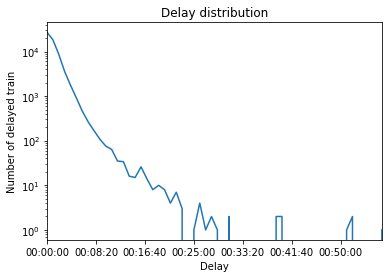

In [118]:
dep_delayed.plot()
plt.xlabel("Delay")
plt.ylabel("Number of delayed train")
plt.title("Delay distribution")
plt.yscale('log')
plt.show()

Even with a log scale, it's seems that most of the delayed trains are less than 3 minutes late.
Since his type of delay is not too penalizing for the users we choose to redefine the limit of the delay.  
*We now consider that a train is delayed from the moment it's over 3 min late.*

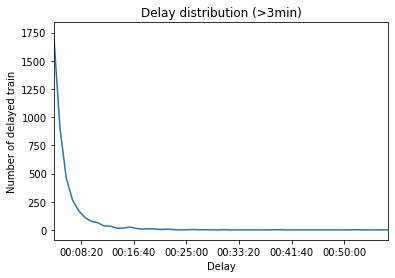

In [119]:
dep_delayed.loc[dep_delayed.index > datetime.timedelta(minutes=3)].plot()
plt.xlabel("Delay")
plt.ylabel("Number of delayed train")
plt.title("Delay distribution (>3min)")
plt.show()

We see that the delays are still mainly stuck between 3 minutes and 15 minutes.

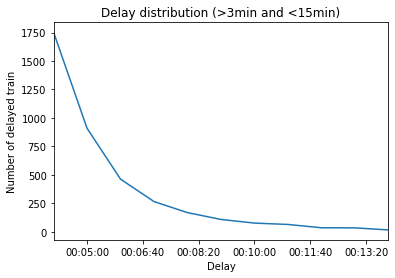

In [120]:
dep_delayed.loc[(dep_delayed.index > datetime.timedelta(minutes=3)) \
                & (dep_delayed.index < datetime.timedelta(minutes=15))].plot()
plt.xlabel("Delay")
plt.ylabel("Number of delayed train")
plt.title("Delay distribution (>3min and <15min)")
plt.show()

In [121]:
# Compute the proportion of delayed train compare to other trains
proportion = dep_delayed.loc[(dep_delayed.index > datetime.timedelta(minutes=3))].sum() / dep_delayed.sum()
print('Proportion of delayed train (>3 min): {} %'.format(round(proportion * 100,2)))

Proportion of delayed train (>3 min): 6.49 %


* What time of the day are trains more likely to be late ?

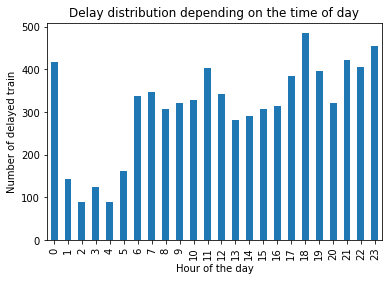

In [147]:
late = df.loc[df['departure_delay'] > datetime.timedelta(minutes=3), ['actual_departure_time']]
times = pd.DatetimeIndex(late['actual_departure_time'])
grouped = late.groupby([times.hour]).count()
grouped.plot(kind='bar', legend=None)
plt.xlabel("Hour of the day")
plt.ylabel("Number of delayed train")
plt.title("Delay distribution depending on the time of day")
plt.show()

There is a decrease in the number of delays in the period from midnight to 4am.  
Except this slot and the leaving work hour (~6pm), delays seem to have an uniform distribution.

* Does a late departing train necessarily have a late arrival delay? (Is there a strong correlation between depature and arrival delay?)

In [158]:
print('Correlation between departure and arrival delay: {}'.format(df['departure_delayed'].corr(df['arrival_delayed'])))

Correlation between departure and arrival delay: 0.5737142382601134


We observe that, even if the train is delayed at the beginning it's not necessarily late to the arrival. 

# Plan for the Milestone 3

## Dataset

For the first analysis we only used a subset of the available data. For the next milestone we will use all the data that we managed to get during this second milestone. 

## Delay analysis

We have already started doing an analysis on this topic. For the next step, we would like to analyze more deeply the geographical part (which stations are the most affected ...).So we will be able to answer the question defined in our readme => *'In which stations the delays are the most frequent?'*

